# Project 1: Pose Graph Optimization (scratch + g2o)
TEAM-ID:     
TEAM-NAME:        
YOUR-ID:      
YOUR-NAME:     

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)

### Submission
Zip a folder of the following:
1. Files that you were provided with: `Project-1.ipynb`, the folders `misc` and `dataset`. Rest of the files asked in the questions below must be generated when i run the code. If generation of any file is computationally intensive, add `filename_backup.extension` where `filename.extension` is the expected name of file when i run the code. (For example, next point.)
2. Add `opt_backup.g2o` (described below) in outermost directory. Here, `opt.g2o` is the expected name of the file when I run the code.
3. For images of any results (like plots), save it in `./misc` folder.

On Moodle, all you have to submit is the jupyter notebook. But make sure to call the necessary functions explicitly (as specified in the notebook). The name of the zipped file being submitted to Moodle Assignment portal MUST BE `ID_Teamname_Firstname`. More details [here](https://www.notion.so/saishubodh/Course-Information-4c9e487b118547b2ba91d24e0dcaf04e#f2707a04f2a0446bac77763b47ba4bac).

On GitHub classrooms, the latest commit before the deadline will be considered as the submission. 

The deadline is Oct 16, 23:55 IST. Please get started ASAP, there is no way you can finish this project during the last few days before the deadline.

### General instructions

This ipython notebook (`.ipynb`) on GitHub is self-sufficient and has all the information you need to get started with the assignment, you don't need any corresponding PDF doc. Just fire up the notebook and get going!

General information like installation instructions in supplementary notebook "Project-1_Code-Walkthrough". Please take a look at it before you start this assignment.

Whenever I mention some `func()` below, I am referring to the "helper functions" in another supplementary notebook "Project-1_Code-Walkthrough" provided to you. Whenever I ask you to insert image below, it is better to save the image in `misc` and load it using `![file_name](file_location)` instead of directly pasting.    

[[CP-]] refers to CheckPoint, you have to ensure you do the tasks at each of the [[CP-]] places below. Not ensuring [[CP-B]] (CheckPoint-Basic) will incur heavy penalty and potentially 0 for that sub-section, and [[CP-M]] (CheckPoint-Marks) has a particular mark weightage depending on your results at that particular CP.

If you face any issues related to coding/installation, please raise an [issue here](https://github.com/Shubodh/MR-project1-pgo/issues). For any conceptual doubts, you can ask on Moodle or Teams as usual.

# 0. Introduction

In this project, we are going to use a non-linear weighted least squares optimization approach to solve the problem of getting a better estimate of our robot's trajectory. Least squares formulations are widely used for optimization, be it computer vision or robotics or machine learning. We will dive deep into it during this project and you will have complete clarity on optimization for vector-valued residual functions. 

In this "Introduction" section, I am going to provide an introduction for SLAM problem for a robot operating in the 2D world. It is 2. section in this Project. The 1D SLAM problem (1.) is far much simpler to understand and will be described directly in the 1. section. 

In a 2D world, a robot has 3 degrees of freedom, i.e. its pose in the world can be expressed by the state vector $\mathbf{x}=(x, y, \theta)^{\mathrm{T}}$. For the scope of this project, we are interested only in the robot's trajectory through the $2 \mathrm{D}$ world, and NOT in distinct landmarks or the surronding map of the environment, i.e. we are only interested in "L"ocalization part of SLAM. 

Therefore, we can represent it as a graph where the vertices represent robot poses $\mathbf{x}_{i}$ and edges represent the spatial constraints between these poses. Such a map is generally called a pose graph.

Two different kinds of constraints are necessary for pose graph SLAM. The first are
odometric constraints that connect two successive states $\mathbf{x}_{i}$ and $\mathbf{x}_{i+1}$ via a motion model. Furthermore, in order to perform loop closing, the robot has to recognize places it already visited before. This place recognition is also a part of the front-end and provides the second type of constraint, the loop closure constraints. These constraints connect two not necessarily successive poses $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$.


![SLAM-trajectory-lc.png](misc/SLAM-trajectory-lc.png)   ![SLAM-trajectory-robust.png](misc/SLAM-trajectory-robust.png) (Source: [Sunderhauf 2012](https://core.ac.uk/download/pdf/89299995.pdf))

You will start from the inaccurate pose graph with odometry and loop closure information and by the end of this Project, you end up with an optimized pose graph (see above images) which should look close to ground truth trajectory. You can watch [this video](https://youtu.be/saVZtgPyyJQ) to get an intuition for what we're about to do.

Okay, that's enough of theory. Let's get out hands dirty with the code!

In [4]:
import matplotlib.pyplot as plt
import math
import os
import jax
import jax.numpy as jnp #see supplementary notebook to see how to use this
from jax import jacfwd
# If you're `importing numpy as np` for debugging purposes, 
# while submitting, please remove 'import numpy' and replace all np's with jnp's.(more in supplementary notebook)

wheel odometry for odometry information# 1. Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. It has been made [available here](https://www.notion.so/saishubodh/Solved-Example-1D-SLAM-weighted-LS-Illustrating-Sparsity-in-SLAM-d8b45893843b4377b07b1d4aa1aab4de). Your first task is to code this from scratch. [[CP-M]]

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct `jax`'s `jacobian`. Its usage is explained in the supplementary notebook.

In [3]:
##############################################################################
# TODO: Code for Section 1                                                   #

def motion_model(x):
    return jnp.array([x[0]+1.1-x[1],x[1]+1-x[2],x[2]+1.1-x[3],x[3]-2.7-x[4],x[0]+0-x[4],x[0]-0])

y_ground = [0,1,2,3,0]
y_obs = [0,1.1,2.1,3.2,0.5]
y_obs = jnp.asarray(y_obs)
epochs = 10
print("The ground truth values")
print(y_ground)
print("The initial observed values")
print(y_obs)

J = jnp.array([[1,-1,0,0,0],[0,1,-1,0,0],[0,0,1,-1,0],[0,0,0,1,-1],[1,0,0,0,-1],[1,0,0,0,0]])
info_matrix = jnp.array([[100,0,0,0,0,0],[0,100,0,0,0,0],[0,0,100,0,0,0],[0,0,0,100,0,0],[0,0,0,0,100,0],[0,0,0,0,0,1000]])
H = J.T@info_matrix@J


for i in range(epochs):
    print("The error in epoch number :%d is %f"%(i,jnp.linalg.norm(jnp.asarray(y_ground)-jnp.asarray(y_obs))))
    f = motion_model(y_obs)
    b = (J.T@info_matrix.T@f).T
    step = -b@jnp.linalg.inv(H)
    y_obs = y_obs + step

print("The values after running gauss newton for the poses")
print(y_obs)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

The ground truth values
[0, 1, 2, 3, 0]
The initial observed values
[0.  1.1 2.1 3.2 0.5]
The error in epoch number :0 is 0.556776
The error in epoch number :1 is 0.173205
The error in epoch number :2 is 0.173205
The error in epoch number :3 is 0.173205
The error in epoch number :4 is 0.173205
The error in epoch number :5 is 0.173205
The error in epoch number :6 is 0.173205
The error in epoch number :7 is 0.173205
The error in epoch number :8 is 0.173205
The error in epoch number :9 is 0.173205
The values after running gauss newton for the poses
[-3.2782577e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01]


# 2. Pose Graph Optimization for 2D SLAM

Things are about to get interesting!

## 2.1 Coding from scratch

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:
1. Initial position
2. Odometry Contraints/Edges: This "edge" information basically tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges
Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://www.notion.so/saishubodh/G2O-Edge-Description-fa07cc28967541dc8a71170de46c5da7) ).

### Details:
1. Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot [[CP-M]] below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](./misc/robot-poses-MR-P1.png)
(Use `draw()` helper function or `g2o_viewer` or `EVO`)

2. Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using [[CP-M]] frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster.

3. Regarding LM iterations, stopping criterion, information matrix values.

    1. [[CP-B]] As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notion page link)](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).
    
    2. [[CP-B]] You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

    3. [[CP-M]] You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (next section), you will be getting a close to ground truth trajectory.

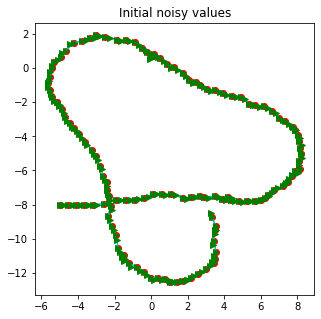

In [18]:
##############################################################################
# TODO: Code for Section 2.1                                                 #
# Plotting trajectory using matplotlib

def frobNorm(P1, P2, str1="JAX jacobian", str2="Manual Jacobian"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")
    
def draw(X, Y, THETA, x,y,theta,x_g,y_g,t_g):
    
    f, axarr = plt.subplots(1,3)
    f.set_figheight(5)
    f.set_figwidth(15)
    
    axarr[0].plot(x_g, y_g, 'ro')
    axarr[0].plot(x_g, y_g, 'c-')

    for i in range(len(t_g)):
        
        x2 = 0.25*math.cos(t_g[i]) + x_g[i]
        y2 = 0.25*math.sin(t_g[i]) + y_g[i]
        axarr[0].plot([x_g[i], x2], [y_g[i], y2], 'g->')
        axarr[0].set_title("Initial noisy values")
    
    axarr[1].plot(X, Y, 'ro')
    axarr[1].plot(X, Y, 'c-')

    for i in range(len(THETA)):
        
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        axarr[1].plot([X[i], x2], [Y[i], y2], 'g->')
        axarr[1].set_title("Ground truth values")
        
    axarr[2].plot(x, y, 'ro')
    axarr[2].plot(x, y, 'c-')

    for i in range(len(theta)):
        
        x2 = 0.25*math.cos(theta[i]) + x[i]
        y2 = 0.25*math.sin(theta[i]) + y[i]
        axarr[2].plot([x[i], x2], [y[i], y2], 'g->')
        axarr[2].set_title("Updated values")
    
    plt.show()

def draw1(X, Y, THETA):

    f, axarr = plt.subplots(1,1)
    f.set_figheight(5)
    f.set_figwidth(5)

    axarr.plot(X, Y, 'ro')
    axarr.plot(X, Y, 'c-')

    for i in range(len(THETA)):

        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        axarr.plot([X[i], x2], [Y[i], y2], 'g->')
        axarr.set_title("Initial noisy values")

    plt.show()
    
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    final_arr = []
    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr=(float(x))
            y_arr=(float(y))
            theta_arr=(float(theta.rstrip('\n')))
            final_arr.append([x_arr,y_arr,theta_arr])

    return jnp.asarray(final_arr)

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

"""

Getting the first pose

"""
vertices = readVertex("./dataset/edges.txt")
vertices_ground = readVertex("./dataset/gt.txt")

"""

Getting the odometry and loop closure edges

"""
ind1, ind2, delx, dely,delt = readEdge("./dataset/edges.txt")


final_vert1 = []
final_vert = []

first_x = vertices[0,0]
first_y = vertices[0,1]
first_t = vertices[0,2]

first = [int(0), first_x, first_y, first_t]
final_vert1.append(first)

first = [ first_x, first_y, first_t]
final_vert.append(first)

"""

Finding the initial poses

"""

for i in range (0,119):

    first_x = first_x + delx[i]*math.cos(first_t) - dely[i]*math.sin(first_t)
    first_y = first_y + dely[i]*math.cos(first_t) + delx[i]*math.sin(first_t)
    first_t+= delt[i]
    
    first = [int(i+1), first_x, first_y, first_t] 
    final_vert1.append(first)
    
    first = [ first_x, first_y, first_t] 
    final_vert.append(first)

final_vert = jnp.asarray(final_vert)

final_initial = final_vert.copy()

with open('./edges-poses.g2o', 'w') as filehandle:
    for place in final_vert1:
        filehandle.writelines("VERTEX_SE2 " )
        for i in place:
            filehandle.writelines("%s " % i)
        filehandle.writelines("\n")
    filehandle.writelines([l for l in open("./dataset/edges.txt").readlines() if "VERTEX_SE2" not in l ])
    
    
vertices_ground.reshape((120,3))

size_x = delx.size
draw1(final_initial[:,0], final_initial[:,1], final_initial[:,2])

Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :1 is 29562.550781
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :2 is 545.924255
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :3 is 250.666962
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :4 is 250.666962
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :5 is 110.468521
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :6 is 110.468521
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :7 is 61.102009
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :8 is 61.102009
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error a

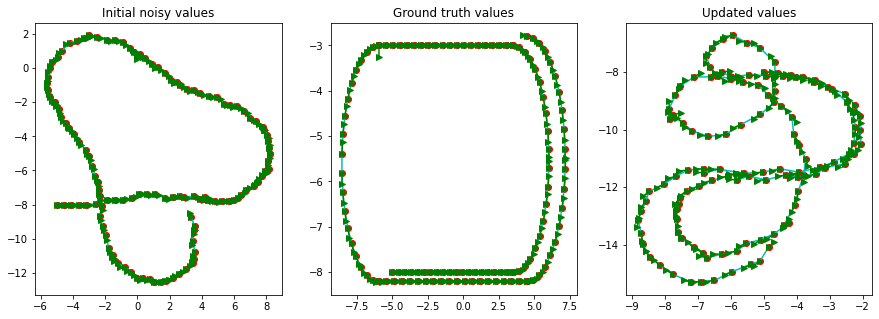

Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :11 is 51.227306
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :12 is 51.227306
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :13 is 47.974026
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :14 is 47.974026
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :15 is 45.028656
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :16 is 45.028656
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :17 is 42.373653
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :18 is 42.373653
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error a

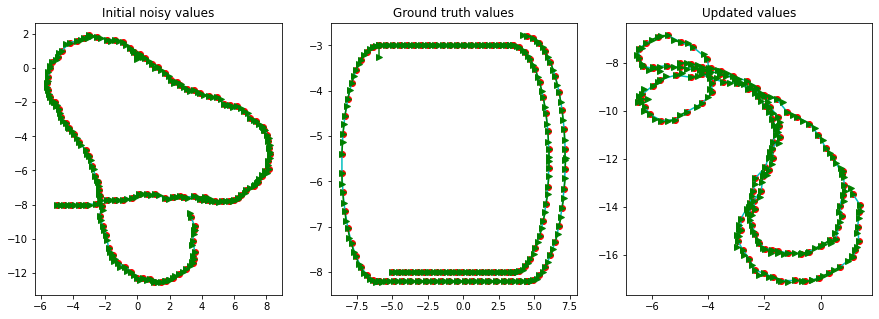

Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :21 is 38.024498
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :22 is 38.024498
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :23 is 36.264965
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :24 is 36.264965
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :25 is 34.729755
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :26 is 34.729755
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :27 is 33.386112
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :28 is 33.386112
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error a

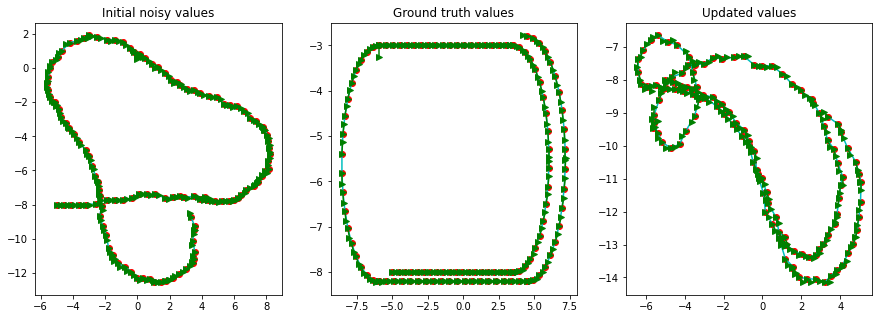

Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :31 is 31.156456
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :32 is 31.156456
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :33 is 30.230589
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :34 is 30.230589
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :35 is 29.411020
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :36 is 29.411020
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :37 is 28.686359
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :38 is 28.686359
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error a

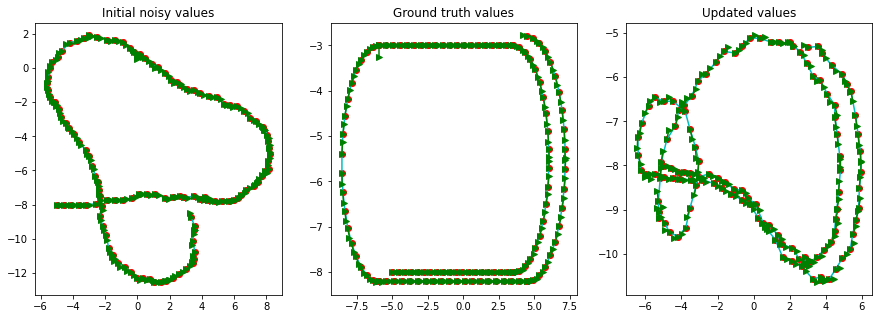

Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :41 is 27.483622
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :42 is 27.483622
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :43 is 26.989006
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :44 is 26.989006
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :45 is 26.555714
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :46 is 26.555714
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :47 is 26.177187
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error after epoch number :48 is 26.177187
Frobenius norm between JAX jacobian and Manual Jacobian is: 0.0
None
The error a

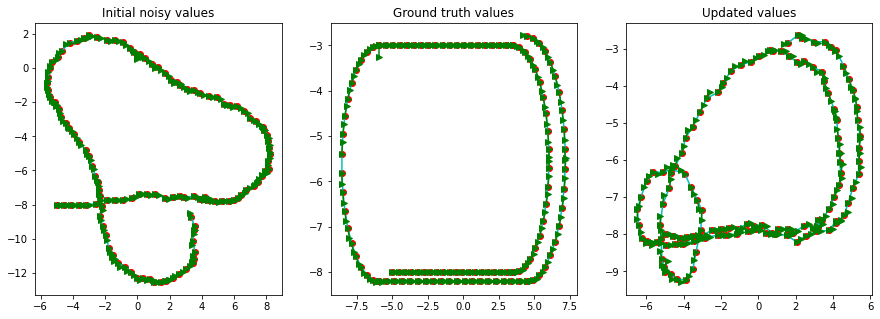

In [19]:
def motion_model1(check,vert,indd1,indd2,dellx,delly,dellt):
    
    if check == 1:
        vert = vert.reshape((3,120))
        vert = vert.T
    residual = []
    """

    Residual for x

    """
    for i in range(size_x):

        i1 = indd1[i]
        i2 = indd2[i]

        start = vert[i1,0]
        to = vert[i2,0]

        dx = dellx[i]
        dy = delly[i]
        t = vert[i1,2]

        
        res = start + dx*jnp.cos(t) - dy*jnp.sin(t)
        
        residual.append(res-to)
    residual.append(vert[0,0]-(-5))    
    """

    Residual for y

    """
    for i in range(size_x):

        i1 = indd1[i]
        i2 = indd2[i]

        start = vert[i1,1]
        to = vert[i2,1]

        dx = dellx[i]
        dy = delly[i]
        t = vert[i1,2]
    
        
        res = start + dy*jnp.cos(t) + dx*jnp.sin(t)

        residual.append(res-to)
    residual.append(vert[0,1]-(-8))    
    """

    Residual for theta

    """
    for i in range(size_x):

        i1 = indd1[i]
        i2 = indd2[i]
    
        start = vert[i1,2]
        to = vert[i2,2]

        dt = dellt[i]

        res = start + dt

        residual.append(res-to)
    residual.append(vert[0,2]-(0))

    residual = jnp.asarray(residual)
    
    return residual

def jaco_calc(vert):
    """

    Jacobian for x

    """
    jacobian = []
    for i in range(size_x):

        i1 = ind1[i]
        i2 = ind2[i]

        dx = delx[i]
        dy = dely[i]
        t = vert[i1,2]

        row = jnp.zeros(360)
        row = jax.ops.index_update(row, jax.ops.index[i1], 1)
        row = jax.ops.index_update(row, jax.ops.index[i2], -1)

        row = jax.ops.index_update(row, jax.ops.index[240+i1], -dx*jnp.sin(t) - dy*jnp.cos(t))

        jacobian.append(row)

    row = jnp.zeros((360))

    row = jax.ops.index_update(row, 0, 1)
    jacobian.append(row)
    """

    Jacobian for y

    """
    for i in range(size_x):

        i1 = ind1[i]
        i2 = ind2[i]

        dx = delx[i]
        dy = dely[i]
        t = vert[i1,2]

        row = jnp.zeros(360)

        row = jax.ops.index_update(row, 120+i1, 1)
        row = jax.ops.index_update(row, 120+i2, -1)
        
        row = jax.ops.index_update(row, 240+i1, -dy*jnp.sin(t) + dx*jnp.cos(t))

        jacobian.append(row)

    row = jnp.zeros(360)

    row = jax.ops.index_update(row, 120, 1)
    jacobian.append(row)

    """

    Jacobian for theta

    """
    for i in range(size_x):

        i1 = ind1[i]
        i2 = ind2[i]


        t = final_vert[i1,2]

        row = jnp.zeros(360)
        
        row = jax.ops.index_update(row, 240+i1, 1)
        row = jax.ops.index_update(row, 240+i2, -1)


        jacobian.append(row)

    row = jnp.zeros(360)
    row = jax.ops.index_update(row, 240, 1)
    jacobian.append(row)

    jacobian = jnp.asarray(jacobian)
    
    return jacobian

"""

Generating the information matrix

"""
values = [0,140,280]
info_mat = []

for val in values:
    
    for i in range(119):

        info = jnp.zeros(420)
        info = jax.ops.index_update(info,jax.ops.index[val+i],25)
        info_mat.append(info)
        
    for i in range(119,139):

        info = jnp.zeros(420)
        info = jax.ops.index_update(info,jax.ops.index[val+i],250)
        info_mat.append(info)
        
    info = jnp.zeros(420)
    info = jax.ops.index_update(info,jax.ops.index[val+139],500)
    info_mat.append(info)    
    
info_mat = jnp.asarray(info_mat)

"""

JAX jacobian
"""

def jax_jacob(vert,inddd1,inddd2,delllx,dellly,delllt):
    
    X = vert[:,0]
    Y = vert[:,1]
    T = vert[:,2]
    wrt_diff = jnp.vstack((X,jnp.vstack((Y,T))))
    f = lambda wrt_diff:motion_model1(1,wrt_diff,inddd1,inddd2,delllx,dellly,delllt)
    J = jacfwd(f)
    J_final = J(wrt_diff)
    return J_final.reshape((420,360))
    
epochs = 50
lamda = 0.01
x_factor = 10

for i in range(epochs):

    
    f1 = motion_model1(0,final_vert,ind1,ind2,delx,dely,delt)
    
    error1 = 0.5*f1.T@info_mat.T@f1
    
    jnp_jac = jax_jacob(final_vert,ind1,ind2,delx,dely,delt)
    jacobian = jaco_calc(final_vert)
    
    H = jacobian.T@info_mat@jacobian
    identit = jnp.eye(H.shape[0],H.shape[1])
    
    for j in range(identit.shape[0]):
            identit = jax.ops.index_update(identit,jax.ops.index[j,j],H[j,j])
            
    modified_jaco = H + lamda*identit
    print(frobNorm(jnp_jac, jacobian))
    b = (jacobian.T@info_mat.T@f1)
    step = -jnp.linalg.inv(modified_jaco)@b   
    steppie = step.reshape((3,120))
    final_vert1 = final_vert + steppie.T
    
    f2 = motion_model1(0,final_vert1,ind1,ind2,delx,dely,delt)
    error2 = 0.5*f2.T@info_mat.T@f2
    
    if (error2<error1):
        
        print("The error after epoch number :%d is %f"%(i+1,0.5*f2.T@info_mat.T@f2))
        
        final_vert = final_vert + steppie.T
        lamda = lamda/x_factor
        
    else:
        
        print("The error after epoch number :%d is %f"%(i+1,0.5*f1.T@info_mat.T@f1))
        lamda = lamda*x_factor

    if (i+1)%10 == 0:
        draw(vertices_ground[:,0],vertices_ground[:,1],vertices_ground[:,2],final_vert[:,0],final_vert[:,1],final_vert[:,2],final_initial[:,0],final_initial[:,1],final_initial[:,2])

count = -1
with open('./opt.g2o', 'w') as filehandle:
    for place in final_vert:
        filehandle.writelines("VERTEX_SE2 " )
        count+=1
        filehandle.writelines("%s " % count)
        for i in place:
            filehandle.writelines("%s " % i)
        filehandle.writelines("\n")
    filehandle.writelines([l for l in open("./dataset/edges.txt").readlines() if "VERTEX_SE2" not in l ])
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

## 2.1 Answer

Give a detailed answer addressing the above questions. When I run the above code, it should follow points described above (such as plots at every 10 steps) and (When I run the above code, it should) write the optimized poses to a file named `opt.g2o`. As a backup, save another file `opt_backup.g2o` in an offline manner beforehand.

That apart, save important plots and add them here so that it can supplement your answer, for example you could add plots at crucial stages of optimization. You have to add useful metrics/plots from `EVO` (refer to supplementary notebook). Using EVO, the bare minimum you have to report is `mean absolute pose error (ape)` and `mean relative pose error (rpe)`. However, you are encouraged to use tools like `evo_traj` and [more](https://github.com/MichaelGrupp/evo/#command-line-interface) and add more plots/metrics. Marks will be awarded based on overall analysis & presentation which would reflect your understanding.

Note that `EVO` and `g2o_viewer` (below) could help you in debugging.

Add answer for 2.1 here:




                                

|Weight of the odometry constraint |Weight of the loop closure constraint |Weight of the anchor point|Final error|No. of epochs run|
|:---------------:|:-------------:|:---------------------:|:----------:|:----------:|
|5|700|1000|7.599809|50|
|25|250|500|25.847334|50|
|100|700|1000|93.852196|50|
|500|700|1000|444.577515|50|
|500|500|500|435.263062|50|
|500|700|300|444.576233|50|


# Ouputs when the information matrix is 500,700,1000
### The final trajectory is
![500,700,1000.png](./misc/500,700,1000.png)

### Mean absolute pose error (APE)

1. max	10.072628
2. mean	5.232458
3. median	5.594071
4. min	0.000000
5. rmse	6.085838
6. sse	4444.490851
7. std	3.107862

![1ape.png](./misc/1ape.png)

### RPE

       max	0.286838
      mean	0.116621
    median	0.108931
       min	0.006284
      rmse	0.132585
       sse	2.091869
       std	0.063074
![1rpe.png](./misc/1rpe.png)

### Trajectory information

Ground truth
1. path length (m)	52.976517997999295
2. pos_end (m)	[-2.8 -4.5  0. ]
3. pos_start (m)	[-8.  5.  0.]
--------------------------------------------------------------------------------

Optimized trajectory

1. path length (m)	53.77212667528096
2. pos_end (m)	[-0.18961288  3.8593988   0.        ]
3. pos_start (m)	[-8.  5.  0.]

![traj.png](./misc/1traj.png)

# 500,500,500
## The final trajectory for 500,500,500
![500,500,500.png](./misc/500,500,500.png)

### Mean absolute pose error (APE)

       max	10.024852
      mean	5.209065
    median	5.593650
       min	0.000000
      rmse	6.056787
       sse	4402.160656
       std	3.090358


![1ape.png](./misc/2ape.png)

### RPE

       max	0.286780
      mean	0.116738
    median	0.108972
       min	0.006516
      rmse	0.132991
       sse	2.104708
       std	0.063709

![1rpe.png](./misc/2rpe.png)

### TRAJ

Ground Truth 

1. path length (m)	52.976517997999295
2. pos_end (m)	[-2.8 -4.5  0. ]
3. pos_start (m)	[-8.  5.  0.]
--------------------------------------------------------------------------------
Optimized trajectory 

1. path length (m)	53.78014788869342
2. pos_end (m)	[-0.20299849  3.814176    0.        ]
3. pos_start (m)	[-8.  5.  0.]


![traj.png](./misc/2traj.png)

# 5,700,1000
## The final trajectory for 500,500,500
![5,700,1000.png](./misc/5,700,1000.png)

### Mean absolute pose error (APE)

      max	11.224845
      mean	5.744326
    median	6.064925
       min	0.000362
      rmse	6.768877
       sse	5498.124239
       std	3.580562



![1ape.png](./misc/3ape.png)

### RPE

       max	0.290155
      mean	0.124217
    median	0.113234
       min	0.019381
      rmse	0.139003
       sse	2.299306
       std	0.062387


![1rpe.png](./misc/3rpe.png)

### TRAJ

Ground truth

1. path length (m)	52.976517997999295
2. pos_end (m)	[-2.8 -4.5  0. ]
3. pos_start (m)	[-8.  5.  0.]
--------------------------------------------------------------------------------
Optimized trajectory

1. path length (m)	52.38991321487649
2. pos_end (m)	[-11.236301   -1.6983727   0.       ]
3. pos_start (m)	[-7.9998517  5.00033    0.       ]


![traj.png](./misc/3traj.png)

# 100,700,1000
## The final trajectory for 500,500,500
![100,700,1000.png](./misc/100,700,1000.png)

### Mean absolute pose error (APE)

       max	8.556233
      mean	4.567879
    median	5.048584
       min	0.000002
      rmse	5.278449
       sse	3343.442748
       std	2.645090



![4ape.png](./misc/4ape.png)

### RPE

       max	0.289366
      mean	0.117299
    median	0.115085
       min	0.003212
      rmse	0.132433
       sse	2.087077
       std	0.061477


![4rpe.png](./misc/4rpe.png)

### TRAJ

Ground Truth

1. path length (m)	52.976517997999295
2. pos_end (m)	[-2.8 -4.5  0. ]
3. pos_start (m)	[-8.  5.  0.]
--------------------------------------------------------------------------------
Optimized trajectory

1. path length (m)	53.9644590551192
2. pos_end (m)	[-0.24138495  2.5362182   0.        ]
3. pos_start (m)	[-8.000001  4.999998  0.      ]


![4traj.png](./misc/4traj.png)

# 5,700,1000
## The final trajectory for 500,500,500
![5,700,1000.png](./misc/5,700,1000.png)

### Mean absolute pose error (APE)

      max	11.224845
      mean	5.744326
    median	6.064925
       min	0.000362
      rmse	6.768877
       sse	5498.124239
       std	3.580562



![1ape.png](./misc/3ape.png)

### RPE

       max	0.290155
      mean	0.124217
    median	0.113234
       min	0.019381
      rmse	0.139003
       sse	2.299306
       std	0.062387


![1rpe.png](./misc/3rpe.png)

### TRAJ

Ground truth

1. path length (m)	52.976517997999295
2. pos_end (m)	[-2.8 -4.5  0. ]
3. pos_start (m)	[-8.  5.  0.]
--------------------------------------------------------------------------------
Optimized trajectory

1. path length (m)	52.38991321487649
2. pos_end (m)	[-11.236301   -1.6983727   0.       ]
3. pos_start (m)	[-7.9998517  5.00033    0.       ]


![traj.png](./misc/3traj.png)

# 500,700,300
![100,700,1000.png](./misc/500,700,300.png)

### Mean absolute pose error (APE)

       max	10.085853
      mean	5.238192
    median	5.597448
       min	0.000000
      rmse	6.092944
       sse	4454.876450
       std	3.112125



![4ape.png](./misc/5ape.png)

### RPE

       max	0.286837
      mean	0.116623
    median	0.108890
       min	0.006299
      rmse	0.132588
       sse	2.091958
       std	0.063075


![4rpe.png](./misc/5rpe.png)

### TRAJ

Ground Truth

1. path length (m)	52.976517997999295
2. pos_end (m)	[-2.8 -4.5  0. ]
3. pos_start (m)	[-8.  5.  0.]
--------------------------------------------------------------------------------
Optimized trajectory

1. path length (m)	53.9644590551192
2. pos_end (m)	[-0.19085827  3.8715346   0.        ]
3. pos_start (m)	[-8.  5.  0.]


![4traj.png](./misc/5traj.png)

### Analysis

1. Even though we know that loop closure constraints are more reliable than odometry constraints, giving too much importance to loop closure (5,700,100) may not be good for the final path. It is true that the error is minimized a lot (7.5). However, the output path does not resemble the ground truth in the slightest.

2. We also observe that except for (5,700,1000), the final optimized trajectories look almost the same.

3. After studying the Mean absolute pose errors and Mean relative pose errors of all the above cases, we have observed that the error increases as the information value of the odometry constraint decreases.

4. Perhaps the most obvious observation is that of the increase in the error as we increase the weight of the odometry constraint. This is because the odometry is not as reliable as compared to loop closure and anchor points.



## 2.2 Using g2o's optimization: g2o binary or g2o viewer 

Installation setup is described in supplementary notebook. More details for 2.2.1 and 2.2.2 can be found in the supplementary notebook.

### 2.2.1 Optimizing `edges.txt`
First task is to optimize the poses of dataset you've been working with so far.

### 2.2.2 Optimizing `intel` and `sphere` datasets
You have been given two datasets in the `data` folder. You have to use `g2o_viewer` to optimize these both. You have to experiment with the options/parameters available in the GUI. More instructions in supplementary notebook. You have to experiment till you get the trajectories which look like the following:

<table><tr>
<td> <img src="./misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

## 2.2 Answer

Add images: take screenshot of the GUI of `g2o_viewer` after optimization for all 3 [[CP-M]] and add here. Briefly describe what you had to do (detailed answer is not expected). g2o could potentially give you close to ground truth trajectory for all 3, but if you are unable to get to close to ground truth, add the best you can get.

# Final output for the sphere
![sphere.png](./misc/final_sphere.png)

Experimentation:

We first decided to use the default Gauss Newton optimizer with 10 iterations. However, that did not do much good. 
![sphere.png](./misc/10,gn.jpeg)

Then we increased the number of iterations to 100.We did get a spherical shape but it looked more like a peach than a ball.
![sphere.png](./misc/100,gn.jpeg)

Finally, we decided to use LM with 100 iteration, which looked close to the gorund truth but it had a few bumps on it

![sphere.png](./misc/50,lm.jpeg)

We then decieded to use lm_fix6_3_cholmod which gave outputs closest to the ground truth
![sphere.png](./misc/final_sphere.png)

# Final output for intel
![sphere.png](./misc/intel_final.png)

Experimentation:

After oberving that LM gave the best outputs for the above sphere, we decided to stick with it. So we used lm_fix3_2_cholmod. As we can see, the output is very close to the ground truth. Here, we ran it for 1000 iterations.

# Final output for the noisy poses

![sphere.png](./misc/final_pose.png)

After oberving that LM gave the best outputs for the above sphere, we decided to stick with it. So we used lm_fix3_2_cholmod. As we can see, the output is very close to the ground truth. Here, we ran it for 12 iterations.

###  * Important Information regarding Questions 3  & 4
Note that it is mandatory to attempt EITHER 3 OR 4, only one of it. If you attempt both, the question which you score more will be considered and the other as bonus question. 

It is encouraged for those into robotics/deep learning research to prefer 4 over 3.

# [Bonus*] 3. Deriving Motion model geometrically
\* -> read information above under section "Important Information regarding Questions 3  & 4"

 
The current robot state is as follows: ($i$ and $k$ are interchangably used below, sorry I am too lazy to edit now 😛)  
![robot-situation.png](./misc/robot-situation.png)

Can you derive the below equation using geometry? (Read on)

$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

In other words, we want to find $\delta$'s in terms of $\Delta$'s
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \tag{2}$$

where $\delta$'s are the updates in our motion model equation:
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta \tag{1}$$

Oh yes, $\theta$ is straightforward, i.e. $\delta \theta = \Delta \theta$ but why? 

Using geometry, you could just draw and insert a self-explanatory image as the answer to this question.

If you can derive it without using geometry purely using transform matrices/algebra, that is fine too. Whatever you're comfortable.

## 3. Answer


Your answer here.

Since all our coordinates are with respect to the world frame, we want to represent the changes in the coordinates in the world frame.

1. However, we will get changes in $\Delta x$, $\Delta y$, in the odometry frame because we get the readings from the sensor frame.

2. This the conversion depends on $\theta$ as well.

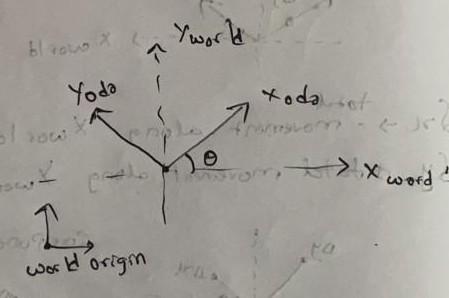



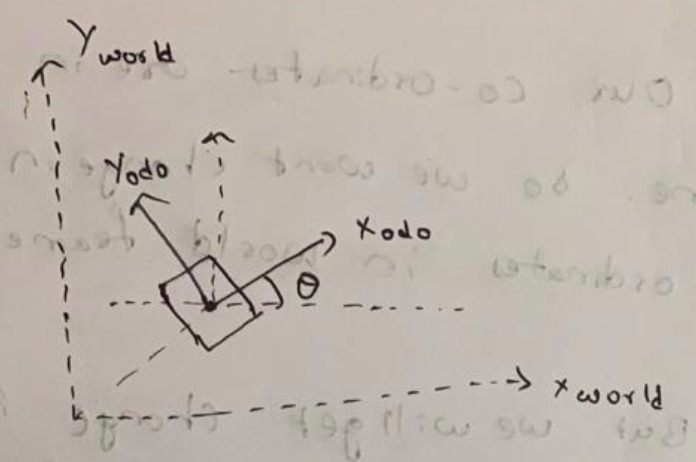

 - $\Delta x$ is the distance along $X_{odo}$
 - $\Delta y$ is the distance along $Y_{odo}$
 

 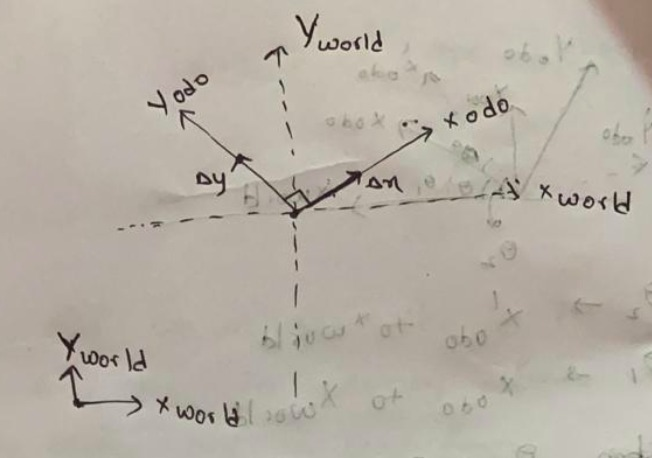
 
 #### Splitting the components
 
 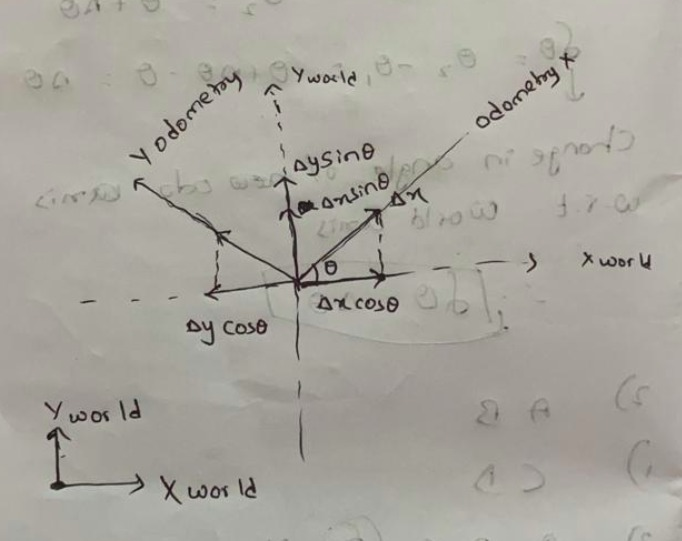
 1. $\delta x$ -> total movement along $X_{world}$
 2. $\delta y$ -> total movement along $Y_{world}$
 
 
 
Thus, 

$\delta x$ = $\Delta x\cos(\theta)$ - $\Delta y\sin(\theta)$  
$\delta y$ = $\Delta x\sin(\theta)$ - $\Delta y\cos(\theta)$ 


### Theta derivation 

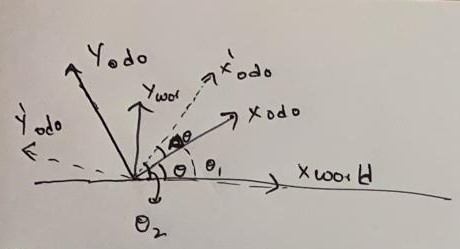

$ \theta _{2} $ -> $X^{'}_{odo}$ to  $X_{world}$
$ \theta _{1} $ -> $X_{odo}$ to  $X_{world}$

Taking $\theta _{1} = \theta$ and $ \theta _{2} = \theta + \Delta \theta$

$\delta \theta = \theta _{2} - \theta _{1} = \theta + \Delta \theta - \theta = \Delta \theta  $

Where $\delta \theta$ is the change in angle of the odometry axis w.r.t the world axis.

Hence, $\delta \theta = \Delta \theta  $

# [Bonus*] 4. Research Paper Reading
\* -> read information above under section "Important Information regarding Questions 3  & 4"

(Do not get intimidated, you are not expected to do a thorough research analysis for this task. A high level understanding is sufficient.)


["Past, Present & Future of SLAM: Towards the Robust Perception Age"](https://arxiv.org/abs/1606.05830) is an exciting survey paper of 2016 which sums up, well, the "past, present & future" of SLAM. Your task is as follows:

1. Go through the sections "IV. LONG-TERM AUTONOMY II: SCALABILITY" & "III. LONG-TERM AUTONOMY I: ROBUSTNESS". Don't worry, you are not expected to have a deep understanding. Skip the parts which you don't understand at all. Go through it at a high level, and take a slightly closer look at "Open Problems" in these sections.

2. Read up common applications of deep learning for computer vision/robotics through blogs online (for example, first 4 points of [this](https://machinelearningmastery.com/applications-of-deep-learning-for-computer-vision/). Again, you are only expected to understand it at a high level, for example, 'semantic segmentation is an application of deep learning for computer vision which is the task of assigning a category to each of the pixels in the image'.

Firstly, summarize your understanding of the above two points.
   
Now, from the understanding you've gathered so far, how would you approach solving those "Open Problems"? 
Can these algorithms help in dealing with some of the issues you might have faced during this project? Can the deep learing based high level understanding of the world help in SLAM? In the context of long term autonomy, imagine tomorrow's world with a buddy robot R2-D2 which follows you wherever you go... Now imagine how easily the trajectory can diverge, how big the map could soon become and how the computation could easily become intractable.   

Answer the above questions in the context of this project and those 2 sections of the survey paper.

## 4. Answer


Your answer here.

**Challenges in SLAM**

    Simultaneous localization and mapping, or SLAM for short, is the process of creating a map using a robot that navigates that environment while using the map it generates. It is just like a person trying to move along an area around and trying to know and navigate through the environment. For making robots autonomous this plays an important role.

    So the robot has to know what's there in the surroundings and need to analyse, map, navigate through it. To know the surroundings it must get the real world inputs in terms of electrical signal this is done through the on-board sensors. Then the analysis needs to be done , here several things come into play the algorithms, computation, storage ,etc. We can see that everything in this process matters, and one needs to solve those with at most care for a long term solution.

**Few works in the past and Unsolved problems:**

    Mapping the environment is highly dependent on sensors and computation. For a long term solution a SLAM system must be robust in many aspects: algorithmic or hardware-related. 

    One of the main problems associated with algorithms failure is data Association, it matches each measurement to the portion of the state the measurement refers to. By wrong association of points to states, robots may map different things to one and make the map incomplete or doesn't merge similar things which leads to confusion of fitting things.
    
    Short term data Association can be solved by taking high samples which may be helpful for making a clear map.
    
    The long term Association is not easy to solve in the front end because of loop closure and detection which is  tricky . The method like Mapping the things as Bag of models helps in studying the relation between the states. Then these models are verified using algos like RANSAC for loop detection and helps in mapping the environment.
    
    But there might always be some mismatch ( like perceptual aliasing) some algos are proposed which reason on the validity of loop closure constraints by looking at the residual error induced by the constraints during optimization.
    
    
**However the problems are not completely solved here are few things**

    In the real world most of the environments are dynamic, the existing solutions might not be solving those completely.
    
    As most algos are iterative, the algos may result in a solution which is not exact minima. So it is important to have a  backup/ recovery system which could detect failure in the system.Sensors and Hardware are things which are continuously exposed to the external environment so the damage / reduction of performance is inevitable over a period of time. So algorithms need to account those too.Due to weather changes the same  location observed at different times of day/ year may look different. But the robot needs to identify this which may help in additional computation.There are many parameters involved on which efficiency output depends. So tuning them manually is not a reliable option, an algorithm needs to be designed to tune them automatically.

    Even if we think of algos which can solve the addressed problems if the algorithm can't run over a wide range of robots it's still not solving the problem. 

    There are a wide variety of robots available in the market, for the robot to perform any computation it needs to be done on hardware which is limited. So our solution should look for memory usage for storage and computation.
    
    One way is by making solution sparse, this can be done by 
    
1. Reducing the number of nodes added to the graph, or by pruning less “informative” nodes and factors. Few solutions work in a way like sparsifying the Hessian matrix (which is computationally high) by solving an L1  -regularized minimization problem.

2. Reducing the number of parameters few approaches are like representing the nodes in the factor graph as the control-points (knots) of the spline which were optimized in a sliding window fashion.The above solution always has a trade off with accuracy so in order to not to risk it we may also do this by parallel computing.  

3. We can use multiple processors simultaneously for calculating sub maps and stitch them together in the final.

4. We can use  multiple robots to map the whole area so that computation on each robot is reduced.

    Even though the methods looks like convincing there are few problems which aren't resolved:
    
    The storing of the Map obtained ( Map representation) is still an unanswered question. The representation of the map takes lots of storage. A compact representation of a map is definitely necessary for long term solution.

    Another problem is how long the robot needs to remember few maps, because over a certain period of time it needs space for new maps in the memory given so there should be an algo developed which can remove unwanted info from the map after a period of time.
    
    The solution of multi robot mapping is still an open problem; it will be complete if we could identify the errors caused by different measurements. SLAM for small robots needs to be done on another device due to hardware limits, so the latency of communication, failure of communication protocol  need to be identified and resolved.

    Let's look at one more topic which is developing rapidly in these days. That is Computer vision, there is lot of things done in this field in recent years. 

**Deep learning in Computer Vision:**

**Few applications are as follows:**

    Image classification involves assigning a label to an entire image or photograph. Some examples of image classification include:
    
1. Labeling an x-ray as cancer or not (binary classification).
2. Classifying a handwritten digit (multiclass classification).
3. Assigning a name to a photograph of a face (multiclass classification).
4. Detection of plant species

    Image classification with segmentation involves assigning a class label to an image and showing the location of the object in the image by a bounding box (drawing a box around the object). This is addition of image classification. Few examples are like locating the area infected by cancer in an X-Ray.
    Object detection  is the task of image classification with localization, although an image may contain multiple objects that require localization and classification. This may involve adding bounding boxes around multiple examples of the same object in the image.  
    Object segmentation, is the task of object detection but pixels in an image are segmented into different categories of object.
    Face recognition involves identifying a specific face out of many given faces. This task is like image recognition but much more complex than recognition of objects.

    These algorithms are seen in our daily lives we come across few application of this like face unlock, Google lens, Google street ,etc which helps in search of objects over internet and navigation in a map etc. So these ideas can also be used in robotic vision for better results.

**Conclusions:**

    The problem of Hardware failures or  noisy reading could be tackled by placing additional sensor which may get give an offset for sensor reading. This is just like placing an additional temperature sensor with a crystal oscillator to get the exact time.
    
    One of the frequent problem in Assignment and project are parameter tuning. The outputs of the graph change according to how we set our parameters. They really play an important role in framing problem and penalizing the error. One can just verify the results over range of params or an optimisation solution can be obtained from the given eqn. In any case they will be highly computional.
    The above problem also can be solved by node sparsifying algorithms which will reduce the number of parameters and help us.

    The knowledge of deep learning will always be useful. Methods are being proposed in those areas to fine tune parameters automatically which might be useful.
    Deep learning with vision is also a powerful tool. We saw many things above. If we can use methods similar to object segmentation and distinguish between movable and non- movable objects then we may be able to create graphs for dynamic areas too. 
    And if we can classify more then according to object we can also make the required storage for this less because the deep learning model will have a better estimate of object.
    Having deep learning algorithms with vision also helps in identifying the same place in different light ,weather settings.

    Few problems like communication failure could be detected by existing protocols in those cases the robot needs to do less computation on board iteratively may eventually build the better MAP.

    The SLAM problem is highly dependent on computation, optimization so relating existing deep learning algos to our problem will lead better results in open problems.


### Fun section
Check the end of your Project-1 homepage on Notion. :)